In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Setup n by n grid
# Input: n = number of grid cell
def field(n):
    # Grid Center Location
    center = np.empty(n)
    edge = np.empty(n+1)
    edge[0] = 0
    for i in range(n):
        center[i] = (2*i+1)*1/n*1/2
        edge[i+1] = (i+1)*1/n
    return center, edge

# Output grid center of current position
def grid_check(center, edge, xi):
    x = xi[0]
    y = xi[1]
    n = len(center)
    for i in range(n):
        minedgex = edge[i]
        maxedgex = edge[i+1]
        for j in range(n):
            minedgey = edge[j]
            maxedgey = edge[j+1]
            if minedgex <= x and x <= maxedgex and minedgey <= y and y <= maxedgey:
                grid_center = np.array([[center[i]], [center[j]]])
    return grid_center

In [2]:
# Wrap2Pi
def wrap2pi(x):
    return np.where(np.abs(x) >= np.pi, (x+np.pi)%(2*np.pi)-np.pi, x)

In [112]:
n = 21
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X,Y = np.meshgrid(x, y)

# Define Initial, Final position of the aggressor
def position(i_x):
    return np.array([x[i_x[0]], y[i_x[1]]])

i_x0 = (int(0.*n), int(0.*n))
i_xf = (int(0.9*n), int(0.35*n))
x0 = position(i_x0)
xf = position(i_xf)
print("x0: {}, xf: {}".format(x0, xf))

# Define cameras and building placement
ang_lim = [0*np.pi/4, 2*np.pi/4] # [rad]
start_ang = ang_lim[0] # [rad]
fov_ang = np.deg2rad(20) # [rad]
rot_vel = (ang_lim[1]-ang_lim[0])/n # [rad/unit time]
fov_rng = 0.75 # [m]
endtime = int(ang_lim[1]*2/rot_vel) # [unit time]
t = np.linspace(0, endtime-1, endtime)

def fov_cam(start_ang, ang_lim, rot_vel, fov_ang, fov_rng, t):
    # Compute Camera angle (centerline of FOV) at each timestamp t
    ang_prev = start_ang
    fov_ang_vec = np.zeros(len(t))
    dt = (t[1]-t[0])
    # Iteration until it hits the angle limit
    iter_lim = ang_lim[1]/rot_vel
    for i in range(len(t)-1):
        if i < iter_lim:
            fov_ang_curr = ang_prev + rot_vel*dt
        # Camera rotates back once reached its rotation limit
        else:
            fov_ang_curr = ang_prev - rot_vel*dt
        ang_prev = fov_ang_curr
        fov_ang_vec[i+1] = fov_ang_curr
    return fov_ang_vec

def position_cam(n_cam, inflate):
    camposx = np.zeros(n_cam)
    camposy = np.zeros(n_cam)
    for i in range(n_cam):
        camx = (i+1)/(n_cam+1)
        camy = 0
        camposx[i] = camx
        camposy[i] = camy
    return  np.array([camposx, camposy]).transpose()

n_cam = 1
campos = position_cam(n_cam, inflate)
camvec = fov_cam(start_ang, ang_lim, rot_vel, fov_ang, fov_rng, t)
print("camvec length: {}".format(len(camvec)))

# Define Initial, Final position of the Camera FOV (centerline)
end_in = int(len(t)/2)#random.randint(0, len(t)-1)
end_ang = camvec[end_in] # Arbirary number for now
print("end_index: {}, FOV angle at final point[deg]: {}".format(end_in, np.rad2deg(camvec[end_in])))

x0: [0. 0.], xf: [0.9  0.35]
camvec length: 42
end_index: 21, FOV angle at final point[deg]: 90.00000000000003


In [113]:
# Compute Cost Function
def costfunc(x0, x1):
    # How do we add restriction from camera FOV?
    s = np.sqrt((x0[0]-x1[0])**2 + (x0[1]-x1[1])**2)
    return s

In [156]:
import copy

# Initialize Final Point
i_x_prev = i_xf
i_theta_prev = end_ang
i_theta = i_theta_prev
i_x = i_x_prev
V = np.zeros((n, n))
live = [[i_x[0], i_x[1]]]
live_hist = {}
live_hist['0'] = live

# Bound within map
def bound(i_x):
    return (i_x[0] >= 0 and i_x[0]<n and i_x[1] >= 0 and i_x[1]<n)

# Bound outside of camera FOV
def bound_cam(i_x, campos, fov_ang_curr, fov_ang, fov_rng):
    # Convert i_x to position
    i_xPos = position(i_x)
    # distance to node
    dist = np.sqrt((campos[0]-i_xPos[0])**2 + (campos[1]-i_xPos[1])**2)
    # Angle to node
    ang = np.arctan2(i_xPos[1]-campos[1], i_xPos[0]-campos[0])
    return (ang >= fov_ang_curr-fov_ang/2 and ang < fov_ang_curr+fov_ang/2 and dist >= 0 and dist < fov_rng)

# Possible Actions
movement = [
    (1, 0), (-1, 0),  # Horizontal
    (0, 1), (0, -1),  # Vertical
    (0, 0)           # Stationary
    #(1, 1), (1, -1), (-1, 1), (-1, -1) # Diagonal
]

# Compute moves from current node
V_data = []
counter = 0
kek = end_in
while len(live) > 0:
    fig = plt.figure()
    new = set()
    end_in_prev = kek
    #print("end_in_prev: {}".format(end_in_prev))
    for p in live:
        #print("counter: {}, p: {}".format(counter, p))
        #print("counter: {}, Position(p): {}".format(counter, position(p)))
        for j in range(len(campos)):
            if not bound_cam(p, campos[j], camvec[end_in_prev], fov_ang, fov_rng):
                for a in movement:
                    pa = (p[0] - a[0], p[1] - a[1])
                    if bound(pa) and not bound_cam(pa, campos[j], camvec[end_in_prev], fov_ang, fov_rng):
                        #print("counter: {}, Position(p): {}".format(counter, position(p)))
                        #print("bound_cam: {}, Position(pa): {}".format(bound_cam(pa, campos[j], camvec[end_in_prev], fov_ang, fov_rng), position(pa)))
                        V_new = costfunc(p, pa) + V[p[0], p[1]]
                        V_old = V[pa[0], pa[1]]
                        if V_old == 0 or V_new < V_old:
                            V[pa[0], pa[1]] = V_new
                            new.add((pa[0], pa[1]))
                            temp = position(pa)
                            plt.plot(temp[0], temp[1], 'xb')
    live = new
    key = str(counter)
    live_hist[key] = live
    V_data.append(copy.copy(V))
    kek = end_in_prev-1
    counter += 1
    
    # ===============================
    # Visualization Purpose
    plt.pcolor(X, Y, V_data[-1].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
    for ind in range(n_cam):
        # Plot Camera Position
        plt.plot(campos[ind,0], campos[ind,1], 'or')

        # Plot Camera FOV
        k = end_in_prev
        theta = camvec[k]
        xend = campos[ind,0]+fov_rng*np.cos(theta)
        yend = campos[ind,1]+fov_rng*np.sin(theta)
        plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--r')

        # FOV LOS
        h = fov_rng*np.tan(fov_ang/2)
        Rprime = np.sqrt(h**2 + fov_rng**2)

        xprime1 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[k]+fov_ang/2)]
        yprime1 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[k]+fov_ang/2)]
        xprime2 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[k]-fov_ang/2)]
        yprime2 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[k]-fov_ang/2)]
        plt.plot(xprime1, yprime1, '-r')
        plt.plot(xprime2, yprime2, '-r')
    
    # Plot x0, xf
    plt.plot(x0[0], x0[1], 'or')
    plt.plot(xf[0], xf[1], 'ob')

    # Remaining Plotting
    plt.grid()
    tol = 0.1
    plt.xlim(-tol, 1+tol)
    plt.ylim(-tol, 1+tol)
    #plt.show()
    plt.close()
    
print("Length V_data: {}".format(len(V_data)))

Length V_data: 33


In [138]:
import matplotlib.animation

# video animation
from tempfile import NamedTemporaryFile
from IPython.display import HTML

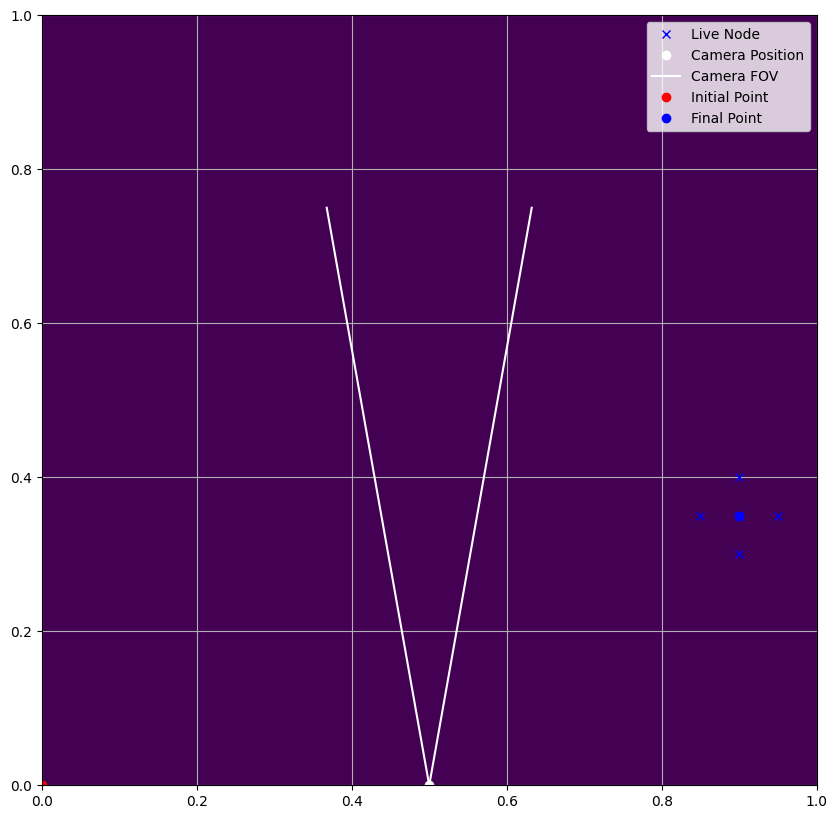

In [171]:
def anim_dyn_prog(V_data):
    nV = len(V_data)
    nP = len(pos_hist_opt)
    fig = plt.figure(figsize=(10, 10))
    plt.pcolor(X, Y, V_data[0].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())   
    
    def update(i):
        fig.clear()
        if i < nV:
            # Grid Coloring
            plt.pcolor(X, Y, V_data[i].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
            
            # Node Population
            # Find current index from dictionary and plot populated node
            curr_key = str(i)
            liveNode = live_hist[curr_key]
            primaris = 0
            for p in liveNode:
                cawl = position(p)
                plt.plot(cawl[0], cawl[1], 'xb', label='Live Node' if primaris == 0 else "")
                primaris += 1
            
            # Camera Visualization
            for ind in range(n_cam):
                # Plot Camera Position
                plt.plot(campos[ind,0], campos[ind,1], 'ow', label = 'Camera Position')

                # Plot Camera FOV
                k = end_in-i%len(t)
                theta = camvec[k]
                xend = campos[ind,0]+fov_rng*np.cos(theta)
                yend = campos[ind,1]+fov_rng*np.sin(theta)
                #plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--w')

                # FOV LOS
                h = fov_rng*np.tan(fov_ang/2)
                Rprime = np.sqrt(h**2 + fov_rng**2)

                xprime1 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[k]+fov_ang/2)]
                yprime1 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[k]+fov_ang/2)]
                xprime2 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[k]-fov_ang/2)]
                yprime2 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[k]-fov_ang/2)]
                plt.plot(xprime1, yprime1, '-w')
                plt.plot(xprime2, yprime2, '-w', label = 'Camera FOV')        
        # Plot x0, xf
        plt.plot(x0[0], x0[1], 'or', label = 'Initial Point')
        plt.plot(xf[0], xf[1], 'ob', label = 'Final Point')

        # Remaining Plotting
        plt.grid()
        tol = 0.1
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.legend(loc="upper right")

    return matplotlib.animation.FuncAnimation(fig, update, frames=nV, interval=100)

# Save Animation into MP4
anim = anim_dyn_prog(V_data)
anim.save('Vdata_Propagation.mp4', fps=5)

In [59]:
# Sanity Check
SanityCheck = type(None)

# Compute Optimal Path
p = i_x0
p_hist_opt = [p]
count = 0
while p != i_xf:
    # Find current time to check where the camera angle is:
    curr_time = count%len(t)
    #print('--count and curr_time--')
    #print(count)
    #print(curr_time)
    print(p)
    pa_opt = None
    V_old = V[p[0], p[1]]
    for a in movement:
        pa = (p[0] + a[0], p[1] + a[1])
        #print('--pa--')
        #print(pa)
        for j in range(len(campos)):
            #print('--cam bound--')
            #print(not bound_cam(pa, campos[j], camvec[curr_time], fov_ang, fov_rng))
            if bound(pa) and not bound_cam(pa, campos[j], camvec[curr_time], fov_ang, fov_rng):
                V_new = V[pa[0], pa[1]]
                if pa_opt is None or pa == i_xf or (V_new < V_opt and V_new < V_old):
                    V_opt = V_new
                    pa_opt = pa
            if pa == i_xf: break
    if count > 1000: break
    p = pa_opt
    # Check if p is empty
    # If p is empty: There is no solution exist s.t. x0 and xf can be connected without detection
    if isinstance(p, SanityCheck):
        break
    else:
        p_hist_opt.append(p)
        count += 1
pos_hist_opt = np.array([position(p, inflate) for p in p_hist_opt])
#print(len(pos_hist_opt))
#print(pos_hist_opt)

(0, 0)
(1, 0)
(2, 0)
(3, 0)
(4, 0)
(5, 0)
(6, 0)
(7, 0)
(8, 0)
(8, 1)
(8, 2)


In [60]:
def anim_dyn_prog(V_data):
    nV = len(V_data)
    nP = len(pos_hist_opt)
    fig = plt.figure(figsize=(10, 10))
    plt.pcolor(inflate*X, inflate*Y, V_data[0].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
    
    def update(i):
        fig.clear()
        if i < nV:
            plt.pcolor(inflate*X, inflate*Y, V_data[i].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
            # Camera Visualization
            for ind in range(n_cam):
                # Plot Camera Position
                plt.plot(campos[ind,0], campos[ind,1], 'or')

                # Plot Camera FOV
                k = i%len(t)
                theta = camvec[k]
                xend = campos[ind,0]+fov_rng*np.cos(theta)
                yend = campos[ind,1]+fov_rng*np.sin(theta)
                plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--r')

                # FOV LOS
                h = fov_rng*np.tan(fov_ang/2)
                Rprime = np.sqrt(h**2 + fov_rng**2)

                xprime1 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[k]+fov_ang/2)]
                yprime1 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[k]+fov_ang/2)]
                xprime2 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[k]-fov_ang/2)]
                yprime2 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[k]-fov_ang/2)]
                plt.plot(xprime1, yprime1, '-r')
                plt.plot(xprime2, yprime2, '-r')
        else:
            plt.pcolor(inflate*X, inflate*Y, V_data[nV-1].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
            j = i - nV + 1
            plt.plot(pos_hist_opt[j-2:j,0], pos_hist_opt[j-2:j,1], '-k')
            plt.plot(pos_hist_opt[j-1,0], pos_hist_opt[j-1,1], 'ok')
            for ind in range(n_cam):
                # Plot Camera Position
                plt.plot(campos[ind,0], campos[ind,1], 'or')

                # Plot Camera FOV
                k = j%len(t)
                theta = camvec[k]
                xend = campos[ind,0]+fov_rng*np.cos(theta)
                yend = campos[ind,1]+fov_rng*np.sin(theta)
                plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--r')

                # FOV LOS
                h = fov_rng*np.tan(fov_ang/2)
                Rprime = np.sqrt(h**2 + fov_rng**2)

                xprime1 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[k]+fov_ang/2)]
                yprime1 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[k]+fov_ang/2)]
                xprime2 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[k]-fov_ang/2)]
                yprime2 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[k]-fov_ang/2)]
                plt.plot(xprime1, yprime1, '-r')
                plt.plot(xprime2, yprime2, '-r')
        
        # Plot x0, xf
        plt.plot(x0[0], x0[1], 'or')
        plt.plot(xf[0], xf[1], 'ob')

        # Remaining Plotting
        #plt.grid()
        tol = 0.01*inflate
        plt.xlim(-tol, inflate*1+tol)
        plt.ylim(-tol, inflate*1+tol)

    return matplotlib.animation.FuncAnimation(fig, update, frames=nV+nP, interval=100)

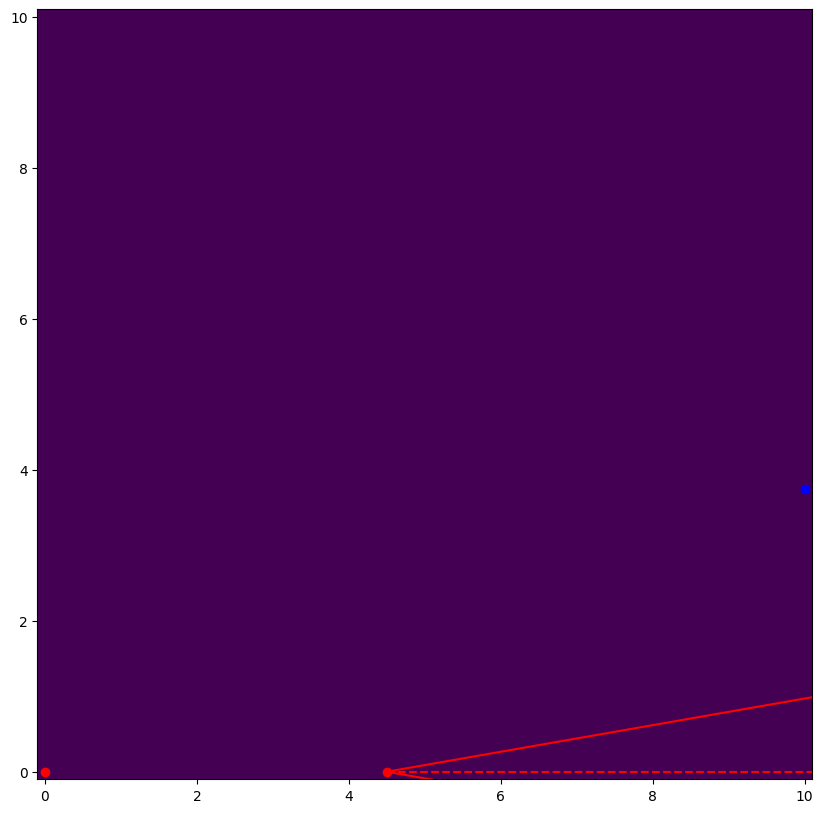

In [61]:
anim = anim_dyn_prog(V_data)
anim.save('test.mp4', fps=2.5)
#video = anim.to_html5_video()
#html = display.HTML(video)
#display.display(html)
#plt.close();

In [ ]:
adfadf
for ind in range(n_cam):
    # Plot Camera Position
    plt.plot(campos[ind,0], campos[ind,1], 'or')

    # Plot Camera FOV
    k = i%len(t)
    theta = camvec[k]
    xend = campos[ind,0]+fov_rng*np.cos(theta)
    yend = campos[ind,1]+fov_rng*np.sin(theta)
    plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--r')

    # FOV LOS
    h = fov_rng*np.tan(fov_ang/2)
    Rprime = np.sqrt(h**2 + fov_rng**2)

    xprime1 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[k]+fov_ang/2)]
    yprime1 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[k]+fov_ang/2)]
    xprime2 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[k]-fov_ang/2)]
    yprime2 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[k]-fov_ang/2)]
    plt.plot(xprime1, yprime1, '-r')
    plt.plot(xprime2, yprime2, '-r')

In [ ]:
nV = len(V_data)
nPhist = len(pos_hist_opt)

n_iter = 0
if nV >= nPhist:
    n_iter = nPhist
elif nV < nPhist:
    n_iter = nV

# Plot Dynamic Programing
for i in range(n_iter):
    fig = plt.figure()
    
    # Camera Visualization
    for j in range(n_cam):
        # Plot Camera Position
        plt.plot(campos[j,0], campos[j,1], 'og')
        
        # Plot Camera FOV
        k = i%len(t)
        theta = camvec[k]
        xend = campos[j,0]+fov_rng*np.cos(theta)
        yend = campos[j,1]+fov_rng*np.sin(theta)
        plt.plot([campos[j,0], xend], [campos[j,1], yend], '--g')
        
        # FOV LOS
        h = fov_rng*np.tan(fov_ang/2)
        Rprime = np.sqrt(h**2 + fov_rng**2)
        
        xprime1 = [campos[j,0], campos[j,0]+Rprime*np.cos(camvec[k]+fov_ang/2)]
        yprime1 = [campos[j,1], campos[j,1]+Rprime*np.sin(camvec[k]+fov_ang/2)]
        xprime2 = [campos[j,0], campos[j,0]+Rprime*np.cos(camvec[k]-fov_ang/2)]
        yprime2 = [campos[j,1], campos[j,1]+Rprime*np.sin(camvec[k]-fov_ang/2)]
        plt.plot(xprime1, yprime1, '-g')
        plt.plot(xprime2, yprime2, '-g')

    # Plot Trajectory
    plt.plot(pos_hist_opt[0:i+1,0], pos_hist_opt[0:i+1,1], '-w')
    plt.plot(pos_hist_opt[i,0], pos_hist_opt[i,1], 'ow')
        
    # Plot x0, xf
    plt.plot(x0[0], x0[1], 'or')
    plt.plot(xf[0], xf[1], 'ob')
    
    plt.pcolor(inflate*X, inflate*Y, V_data[i].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
    plt.plot(x0[1])
    plt.grid()
    tol = 0.01*inflate
    plt.xlim(-tol, inflate*1+tol)
    plt.ylim(-tol, inflate*1+tol)

In [ ]:
fig = plt.figure()

# Camera Visualization
for j in range(n_cam):
    # Plot Camera Position
    plt.plot(campos[j,0], campos[j,1], 'og')

    # Plot Camera FOV
    k = (nPhist-1)%len(t)
    theta = camvec[k]
    xend = campos[j,0]+fov_rng*np.cos(theta)
    yend = campos[j,1]+fov_rng*np.sin(theta)
    plt.plot([campos[j,0], xend], [campos[j,1], yend], '--g')

#        # FOV LOS
    h = fov_rng*np.tan(fov_ang/2)
    Rprime = np.sqrt(h**2 + fov_rng**2)

    xprime1 = [campos[j,0], campos[j,0]+Rprime*np.cos(camvec[k]+fov_ang/2)]
    yprime1 = [campos[j,1], campos[j,1]+Rprime*np.sin(camvec[k]+fov_ang/2)]
    xprime2 = [campos[j,0], campos[j,0]+Rprime*np.cos(camvec[k]-fov_ang/2)]
    yprime2 = [campos[j,1], campos[j,1]+Rprime*np.sin(camvec[k]-fov_ang/2)]
    plt.plot(xprime1, yprime1, '-g')
    plt.plot(xprime2, yprime2, '-g')

# Plot Trajectory
nPhist = len(pos_hist_opt)
plt.plot(pos_hist_opt[:,0], pos_hist_opt[:,1], '-w')
plt.plot(pos_hist_opt[nPhist-1,0], pos_hist_opt[nPhist-1,1], 'ow')

    
# Plot x0, xf
plt.plot(x0[0], x0[1], 'or')
plt.plot(xf[0], xf[1], 'ob')

plt.pcolor(inflate*X, inflate*Y, V_data[nPhist].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
plt.plot(x0[1])
plt.grid()
tol = 0.01*inflate
plt.xlim(-tol, inflate*1+tol)
plt.ylim(-tol, inflate*1+tol)

In [ ]:
adfadfadf

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
from IPython.display import HTML
import numpy as np
# Initinialize Figure for Animation
fig = plt.figure()

# Setup Axis
axis = plt.axes(xlim=(-tol, inflate*1+tol), ylim=(-tol, inflate*1+tol))
plt.grid()


# Initialize a line variable:
line, = axis.plot([], [])

# Initialization:
def init():
    line.set_data([], [])
    return line,

def animate(V_data):
    nV = len(V_data)
    nP = len(pos_hist_opt)

#anim = FuncAnimation(fig=fig, func=anim_dyn_prog(V_data), frames=10, interval=20, cache_frame_data=False)
#video = anim.to_html5_video()
#html = display.HTML(video)
#display.display(html)

In [ ]:
for k in range(len(pos_hist_opt)-1):
    fig = plt.figure()
    # Plot Camera Position
    for i in range(n_cam):
        plt.plot(campos[:,0], campos[:,1], 'og')

    # Plot Camera FOV
    for j in range(n_cam):
        curr_time = (k+1)%len(t)
        theta = camvec[curr_time]
        xend = campos[j,0]+fov_rng*np.cos(theta)
        yend = campos[j,1]+fov_rng*np.sin(theta)
        plt.plot([campos[j,0], xend], [campos[j,1], yend], '--g')
        
        # FOV LOS
        h = fov_rng*np.tan(fov_ang/2)
        Rprime = np.sqrt(h**2 + fov_rng**2)
        
        xprime1 = [campos[j,0], campos[j,0]+Rprime*np.cos(theta+fov_ang/2)]
        yprime1 = [campos[j,1], campos[j,1]+Rprime*np.sin(theta+fov_ang/2)]
        xprime2 = [campos[j,0], campos[j,0]+Rprime*np.cos(theta-fov_ang/2)]
        yprime2 = [campos[j,1], campos[j,1]+Rprime*np.sin(theta-fov_ang/2)]
        plt.plot(xprime1, yprime1, '-g')
        plt.plot(xprime2, yprime2, '-g')
        #ax.fill_between(x, y1, y2, color = 'r', alpha=0.2)
        

    # Plot x0, xf
    plt.plot(x0[0], x0[1], 'or')
    plt.plot(xf[0], xf[1], 'ob')
    
    # Plot Intermediate Position
    plt.plot(pos_hist_opt[k+1,0], pos_hist_opt[k+1,1], 'xb')
    plt.plot([pos_hist_opt[k,0], pos_hist_opt[k+1,0]], [pos_hist_opt[k,1], pos_hist_opt[k+1,1]], '-b')

    # Plot Setting
    lim = [0, inflate*1, 0, inflate*1]
    tol = 0.01*inflate
    plt.grid()
    plt.xlim(-tol, inflate*1+tol)
    plt.ylim(-tol, inflate*1+tol)
    plt.show()

In [ ]:
fig = plt.figure()
# Plot Center and Grid Edge
for i in range(n):
    for j in range(n):
        plt.plot(center[i], center[j], '.k')
for i in range(n+1):
    plt.plot([edge[i], edge[i]], [0, inflate*1], '--k')
    plt.plot([0, inflate*1], [edge[i], edge[i]], '--k')

# Plot Camera Position
for i in range(n_cam):
    plt.plot(campos[:,0], campos[:,1], 'og')

# Plot Camera FOV
for i in range(len(t)):
    theta = camvec[i]
    xend = campos[:,0]+fov_rng*np.cos(theta)
    yend = campos[:,1]+fov_rng*np.sin(theta)
    plt.plot([campos[:,0], xend], [campos[:,1], yend], '-r')
    
# Plot x0, xf
plt.plot(x0[0], x0[1], 'xr')
plt.plot(xf[0], xf[1], 'xb')
plt.plot(center0[0], center0[1], 'or')
plt.plot(centerf[0], centerf[1], 'ob')

# Plot Optimal Path
plt.plot(pos_hist_opt[:,0], pos_hist_opt[:,1], '-b')

# Plot Setting
lim = [0, inflate*1, 0, inflate*1]
plt.axis(lim)
plt.axis('equal')
plt.show()

In [ ]:
from matplotlib.animation import FuncAnimation

# Figure Initialization
fig = plt.figure()

# Make x-axis, y-axis
axis = plt.axis(xlim=(0, inflate*1), ylim=(0, inflate*1))

